<a href="https://colab.research.google.com/github/homeromolina/Analise_Acoes_IBOV/blob/main/KNN_Algorithm_House_Prices.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>



> We will identifies the Euclidean distance/K nearest data points using the dataset of house prices to make a predicition. 





## **Imports and Settings**

In [28]:
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

from pathlib import Path
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import spearmanr
from sklearn.neighbors import (KNeighborsClassifier, 
                               KNeighborsRegressor)
from sklearn.model_selection import (cross_val_score, 
                                     cross_val_predict, 
                                     GridSearchCV)
from sklearn.feature_selection import mutual_info_regression
from sklearn.preprocessing import StandardScaler, scale
from sklearn.pipeline import Pipeline
from sklearn.metrics import make_scorer
from yellowbrick.model_selection import ValidationCurve, LearningCurve

from sklearn.metrics import (mean_squared_error,
                             mean_absolute_error,
                             mean_squared_log_error, 
                             median_absolute_error, 
                             explained_variance_score, 
                             r2_score)

sns.set_style('whitegrid')

# **Data**

source: https://www.kaggle.com/datasets/harlfoxem/housesalesprediction?resource=download

In [6]:
from google.colab import drive
drive.mount('/content/drive')

pasta_raiz = '/content/drive/My Drive/'

import pandas as pd

house_sales = pd.read_csv('/content/drive/My Drive/kc_house_data.csv')
house_sales

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,7129300520,20141013T000000,221900.0,3,1.00,1180,5650,1.0,0,0,...,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,6414100192,20141209T000000,538000.0,3,2.25,2570,7242,2.0,0,0,...,7,2170,400,1951,1991,98125,47.7210,-122.319,1690,7639
2,5631500400,20150225T000000,180000.0,2,1.00,770,10000,1.0,0,0,...,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
3,2487200875,20141209T000000,604000.0,4,3.00,1960,5000,1.0,0,0,...,7,1050,910,1965,0,98136,47.5208,-122.393,1360,5000
4,1954400510,20150218T000000,510000.0,3,2.00,1680,8080,1.0,0,0,...,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21608,263000018,20140521T000000,360000.0,3,2.50,1530,1131,3.0,0,0,...,8,1530,0,2009,0,98103,47.6993,-122.346,1530,1509
21609,6600060120,20150223T000000,400000.0,4,2.50,2310,5813,2.0,0,0,...,8,2310,0,2014,0,98146,47.5107,-122.362,1830,7200
21610,1523300141,20140623T000000,402101.0,2,0.75,1020,1350,2.0,0,0,...,7,1020,0,2009,0,98144,47.5944,-122.299,1020,2007
21611,291310100,20150116T000000,400000.0,3,2.50,1600,2388,2.0,0,0,...,8,1600,0,2004,0,98027,47.5345,-122.069,1410,1287


In [7]:
house_sales = house_sales.drop(
    ['id', 'zipcode', 'lat', 'long', 'date'], axis=1)
house_sales.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21613 entries, 0 to 21612
Data columns (total 16 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   price          21613 non-null  float64
 1   bedrooms       21613 non-null  int64  
 2   bathrooms      21613 non-null  float64
 3   sqft_living    21613 non-null  int64  
 4   sqft_lot       21613 non-null  int64  
 5   floors         21613 non-null  float64
 6   waterfront     21613 non-null  int64  
 7   view           21613 non-null  int64  
 8   condition      21613 non-null  int64  
 9   grade          21613 non-null  int64  
 10  sqft_above     21613 non-null  int64  
 11  sqft_basement  21613 non-null  int64  
 12  yr_built       21613 non-null  int64  
 13  yr_renovated   21613 non-null  int64  
 14  sqft_living15  21613 non-null  int64  
 15  sqft_lot15     21613 non-null  int64  
dtypes: float64(3), int64(13)
memory usage: 2.6 MB


# **Cleaning and Tranforming Features**

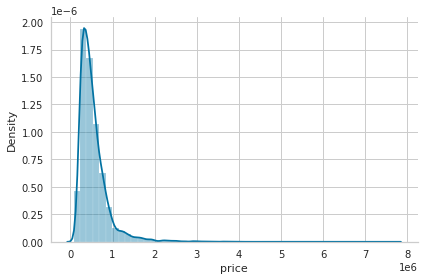

In [8]:
sns.distplot(house_sales.price)
sns.despine()
plt.tight_layout();

In [9]:
# Use log transform

X_all = house_sales.drop('price', axis=1)
y = np.log(house_sales.price)



> **Univariate feature selection:** Univariate feature selection works by selecting the best features based on univariate statistical tests. It can be seen as a preprocessing step to an estimator. Scikit-learn exposes feature selection routines as objects that implement the transform method:

*   SelectKBest removes all but the highest scoring features

*   SelectPercentile removes all but a user-specified highest scoring percentage of features using common univariate statistical tests for each feature: false positive rate SelectFpr, false discovery rate SelectFdr, or family wise error SelectFwe.

*   GenericUnivariateSelect allows to perform univariate feature selection with a configurable strategy. This allows to select the best univariate selection strategy with hyper-parameter search estimator.



> The methods based on F-test estimate the degree of linear dependency between two random variables. On the other hand, mutual information methods can capture any kind of statistical dependency, but being nonparametric, they require more samples for accurate estimation.

source: https://scikit-learn.org/stable/modules/feature_selection.html#univariate-feature-selection



In [10]:
mi_reg = pd.Series(mutual_info_regression(X_all, y),
                   index=X_all.columns).sort_values(ascending=False)
mi_reg

sqft_living      0.348937
grade            0.345092
sqft_living15    0.270002
sqft_above       0.260914
bathrooms        0.208040
sqft_lot15       0.086333
bedrooms         0.081630
yr_built         0.078337
floors           0.072909
sqft_basement    0.069339
sqft_lot         0.062363
view             0.056039
condition        0.017008
waterfront       0.013548
yr_renovated     0.009707
dtype: float64

In [11]:
X = X_all.loc[:, mi_reg.iloc[:10].index]

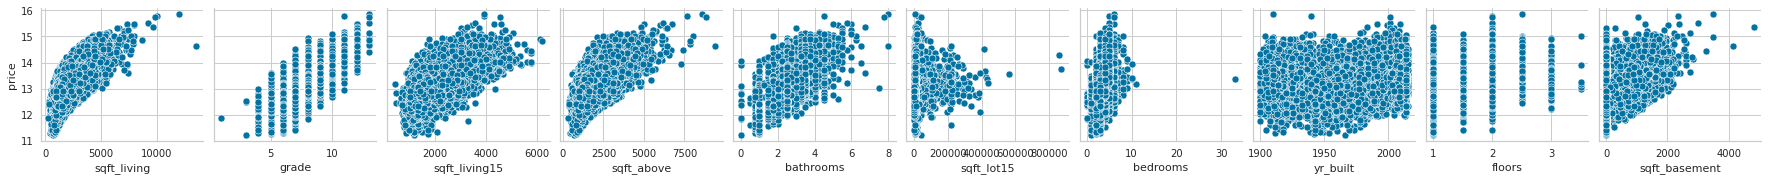

In [13]:
# Bivariate Scatter Plots - 

g = sns.pairplot(X.assign(price=y), y_vars=['price'], x_vars=X.columns)
sns.despine();

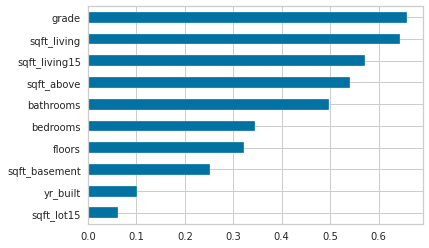

In [17]:
# Understanding the features correlations with prices

correl = X.apply(lambda x: spearmanr(x, y)[0])
correl.sort_values().plot.barh();

# **KNN Regression**

In [19]:
X

,sqft_living,grade,sqft_living15,sqft_above,bathrooms,sqft_lot15,bedrooms,yr_built,floors,sqft_basement
0,1180,7,1340,1180,1.00,5650,3,1955,1.0,0
1,2570,7,1690,2170,2.25,7639,3,1951,2.0,400
2,770,6,2720,770,1.00,8062,2,1933,1.0,0
3,1960,7,1360,1050,3.00,5000,4,1965,1.0,910
4,1680,8,1800,1680,2.00,7503,3,1987,1.0,0
...,...,...,...,...,...,...,...,...,...,...
21608,1530,8,1530,1530,2.50,1509,3,2009,3.0,0
21609,2310,8,1830,2310,2.50,7200,4,2014,2.0,0
21610,1020,7,1020,1020,0.75,2007,2,2009,2.0,0
21611,1600,8,1410,1600,2.50,1287,3,2004,2.0,0


In [20]:
# Standardize a dataset along any axis, center to the mean and component wise scale to unit variance.

X_scaled = scale(X)
X_scaled

array([[-0.97983502, -0.55883575, -0.9433552 , ..., -0.54489777,
        -0.915427  , -0.65868104],
       [ 0.53363434, -0.55883575, -0.43268619, ..., -0.6810785 ,
         0.93650577,  0.2451414 ],
       [-1.42625404, -1.40958711,  1.07013975, ..., -1.29389179,
        -0.915427  , -0.65868104],
       ...,
       [-1.15404732, -0.55883575, -1.41025258, ...,  1.29354209,
         0.93650577, -0.65868104],
       [-0.52252773,  0.29191561, -0.8412214 , ...,  1.12331618,
         0.93650577, -0.65868104],
       [-1.15404732, -0.55883575, -1.41025258, ...,  1.25949691,
         0.93650577, -0.65868104]])

In [21]:
model = KNeighborsRegressor()
model.fit(X=X_scaled, y=y)

KNeighborsRegressor()

In [23]:
y_pred = model.predict(X_scaled)
y_pred

array([12.62828919, 13.18425086, 12.49356399, ..., 12.80192119,
       12.8752583 , 12.80192119])



> **Calculating the prediction error:** is the deviation from the true value, whereas a residual is the deviation from a estimated value.



In [41]:
error = (y - y_pred).rename('Prediction Errors')
error

0       -0.318307
1        0.011363
2       -0.392852
3        0.484024
4        0.428821
           ...   
21608   -0.163507
21609    0.016639
21610    0.102537
21611    0.023962
21612   -0.110341
Name: Prediction Errors, Length: 21613, dtype: float64

In [42]:
mean_absolute_error(y,y_pred)

0.19702559319800597

In [44]:
scores = dict(
    rmse=np.sqrt(mean_squared_error(y_true=y, y_pred=y_pred)),
    rmsle=np.sqrt(mean_squared_log_error(y_true=y, y_pred=y_pred)),
    mean_ae=mean_absolute_error(y_true=y, y_pred=y_pred),
    median_ae=median_absolute_error(y_true=y, y_pred=y_pred),
    r2score=explained_variance_score(y_true=y, y_pred=y_pred)
)
scores

{'mean_ae': 0.19702559319800597,
 'median_ae': 0.15785845716787605,
 'r2score': 0.7650115926007489,
 'rmse': 0.25543770517201075,
 'rmsle': 0.018243791325646897}

In [45]:
y.describe()

# We can see that the our mean_ae < mean/std, soo we are going ok

count    21613.000000
mean        13.047817
std          0.526685
min         11.225243
25%         12.682152
50%         13.017003
75%         13.377006
max         15.856731
Name: price, dtype: float64

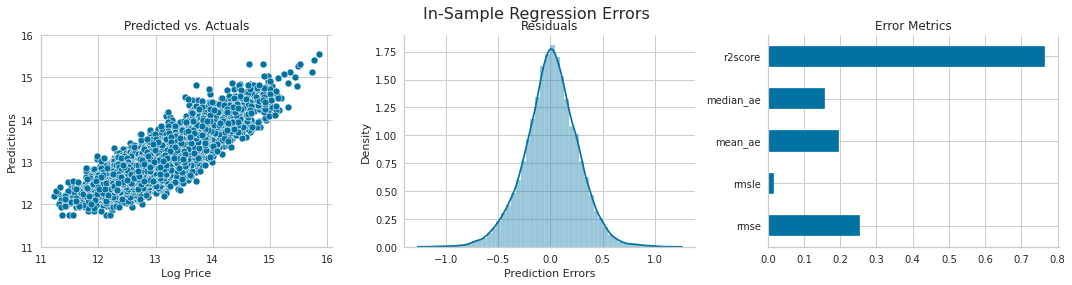

In [47]:
fig, axes = plt.subplots(ncols=3, figsize=(15, 4))
sns.scatterplot(x=y, y=y_pred, ax=axes[0])
axes[0].set_xlabel('Log Price')
axes[0].set_ylabel('Predictions')
axes[0].set_ylim(11, 16)
axes[0].set_title('Predicted vs. Actuals')
sns.distplot(error, ax=axes[1])
axes[1].set_title('Residuals')
pd.Series(scores).plot.barh(ax=axes[2], title='Error Metrics')
fig.suptitle('In-Sample Regression Errors', fontsize=16)
sns.despine()
fig.tight_layout()
fig.subplots_adjust(top=.88)

In [51]:
error.describe()

count    21613.000000
mean         0.008152
std          0.255313
min         -1.162983
25%         -0.145707
50%          0.011619
75%          0.168637
max          1.152403
Name: Prediction Errors, dtype: float64

# **Cross-Validation**

In [52]:
def rmse(y_true, pred):
    return np.sqrt(mean_squared_error(y_true=y_true, y_pred=pred))

rmse_score = make_scorer(rmse)

In [54]:
cv_rmse = {}
n_neighbors = [1] + list(range(5, 51, 5))
for n in n_neighbors:
    pipe = Pipeline([('scaler', StandardScaler()),
                     ('knn', KNeighborsRegressor(n_neighbors=n))])                    
    cv_rmse[n] = cross_val_score(pipe, 
                                X=X, 
                                y=y,
                                scoring=rmse_score,
                                cv=5)

In [55]:
cv_rmse = pd.DataFrame.from_dict(cv_rmse, orient='index')
best_n, best_rmse = cv_rmse.mean(1).idxmin(), cv_rmse.mean(1).min()
cv_rmse = cv_rmse.stack().reset_index()
cv_rmse.columns =['n', 'fold', 'RMSE']

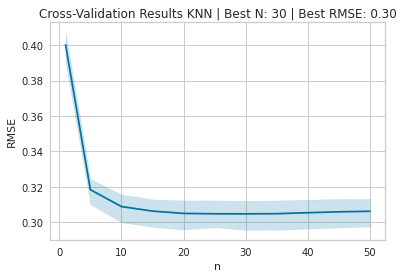

In [56]:
ax = sns.lineplot(x='n', y='RMSE', data=cv_rmse)
ax.set_title(f'Cross-Validation Results KNN | Best N: {best_n:d} | Best RMSE: {best_rmse:.2f}');

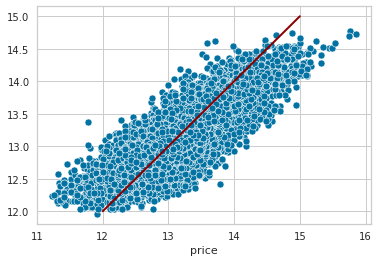

In [57]:
pipe = Pipeline([('scaler', StandardScaler()),
                 ('knn', KNeighborsRegressor(n_neighbors=best_n))])
y_pred = cross_val_predict(pipe, X, y, cv=5)

ax = sns.scatterplot(x=y, y=y_pred)
y_range = list(range(int(y.min() + 1), int(y.max() + 1)))
pd.Series(y_range, index=y_range).plot(ax=ax, lw=2, c='darkred');


In [58]:
# Cross-Validation Errors

error = (y - y_pred).rename('Prediction Errors')
error

0       -0.408473
1        0.064345
2       -0.571139
3        0.411227
4        0.447938
           ...   
21608   -0.229531
21609    0.011111
21610    0.336977
21611   -0.024038
21612    0.136106
Name: Prediction Errors, Length: 21613, dtype: float64

In [59]:
scores = dict(
    rmse=np.sqrt(mean_squared_error(y_true=y, y_pred=y_pred)),
    rmsle=np.sqrt(mean_squared_log_error(y_true=y, y_pred=y_pred)),
    mean_ae=mean_absolute_error(y_true=y, y_pred=y_pred),
    median_ae=median_absolute_error(y_true=y, y_pred=y_pred),
    r2score=explained_variance_score(y_true=y, y_pred=y_pred)
)
scores

{'mean_ae': 0.23992918361681137,
 'median_ae': 0.19955035231321006,
 'r2score': 0.666111660042602,
 'rmse': 0.30495022623372164,
 'rmsle': 0.02174838525510411}

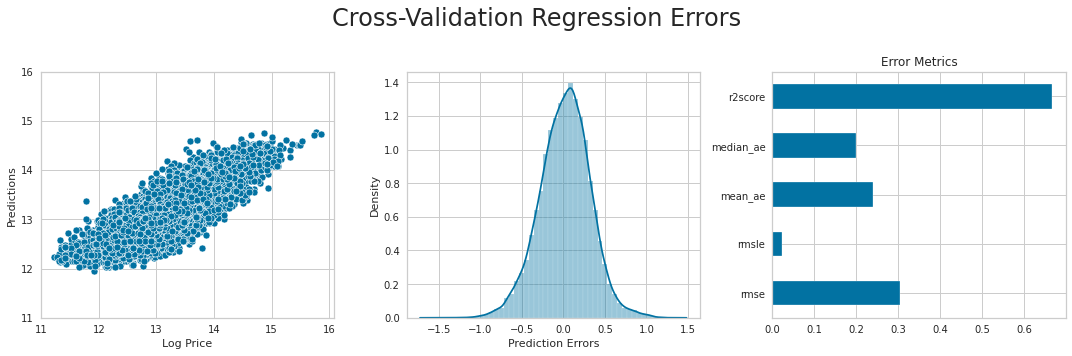

In [60]:
fig, axes = plt.subplots(ncols=3, figsize=(15, 5))
sns.scatterplot(x=y, y=y_pred, ax=axes[0])
axes[0].set_xlabel('Log Price')
axes[0].set_ylabel('Predictions')
axes[0].set_ylim(11, 16)
sns.distplot(error, ax=axes[1])
pd.Series(scores).plot.barh(ax=axes[2], title='Error Metrics')
fig.suptitle('Cross-Validation Regression Errors', fontsize=24)
fig.tight_layout()
plt.subplots_adjust(top=.8);

# **GridSearchCV**

In [61]:
pipe = Pipeline([('scaler', StandardScaler()), 
                 ('knn', KNeighborsRegressor())])

n_folds = 5
n_neighbors = tuple(range(5, 101, 5))

param_grid = {'knn__n_neighbors': n_neighbors}

estimator = GridSearchCV(estimator=pipe,
                         param_grid=param_grid,
                         cv=n_folds,
                         scoring=rmse_score,
                        )
estimator.fit(X=X, y=y)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('knn', KNeighborsRegressor())]),
             param_grid={'knn__n_neighbors': (5, 10, 15, 20, 25, 30, 35, 40, 45,
                                              50, 55, 60, 65, 70, 75, 80, 85,
                                              90, 95, 100)},
             scoring=make_scorer(rmse))

In [62]:
cv_results = estimator.cv_results_
cv_results

{'mean_fit_time': array([0.04718366, 0.04673352, 0.04826488, 0.03046651, 0.0311872 ,
        0.05976543, 0.03785782, 0.05170679, 0.04512739, 0.03085065,
        0.03299627, 0.03076658, 0.03139925, 0.03091974, 0.03116283,
        0.03343391, 0.03227701, 0.03097491, 0.03208899, 0.03113751]),
 'mean_score_time': array([0.47324781, 0.54741669, 0.58963203, 0.37676325, 0.40849028,
        0.7143724 , 0.68075266, 0.89107223, 0.75821104, 0.52774467,
        0.54150581, 0.57219176, 0.58593531, 0.60861754, 0.61636863,
        0.6431139 , 0.65020008, 0.67247729, 0.68986297, 0.70330276]),
 'mean_test_score': array([0.31843621, 0.3089344 , 0.30637413, 0.30506989, 0.30485121,
        0.3048046 , 0.30491731, 0.30545483, 0.30596727, 0.30627871,
        0.30657359, 0.30701424, 0.30755728, 0.30811924, 0.30859272,
        0.30914451, 0.30966699, 0.31007889, 0.31052208, 0.31090027]),
 'param_knn__n_neighbors': masked_array(data=[5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70,
                    75

In [65]:
test_scores = pd.DataFrame({fold: cv_results[f'split{fold}_test_score'] for fold in range(n_folds)}, 
                           index=n_neighbors).stack().reset_index()
test_scores.columns = ['k', 'fold', 'RMSE']

In [66]:
mean_rmse = test_scores.groupby('k').RMSE.mean()
best_k, best_score = mean_rmse.idxmin(), mean_rmse.min()



> k = 30 is the best choice with the min RMSE



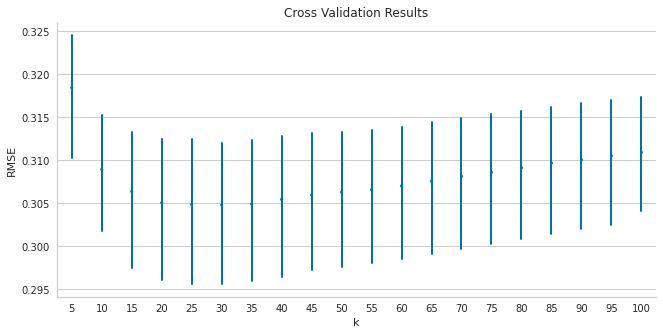

In [69]:
sns.pointplot(x='k', y='RMSE', data=test_scores, scale=.3, join=False, errwidth=2)
plt.title('Cross Validation Results')
sns.despine()
plt.tight_layout()
plt.gcf().set_size_inches(10, 5);

# **Train & Validation Curves mit yellowbricks**

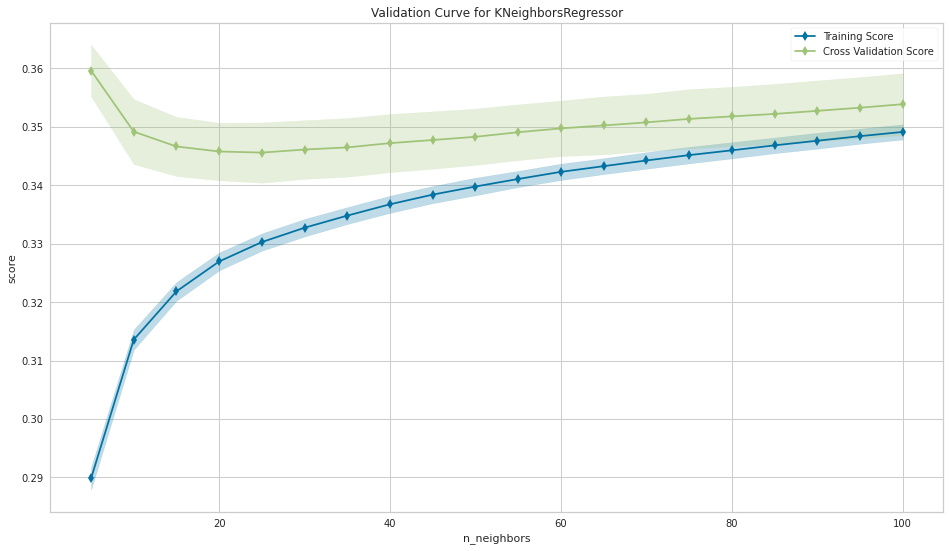

<Figure size 432x288 with 0 Axes>

In [70]:
fig, ax = plt.subplots(figsize=(16, 9))
val_curve = ValidationCurve(KNeighborsRegressor(),
                      param_name='n_neighbors',
                      param_range=n_neighbors,
                      cv=5,
                      scoring=rmse_score,
                      ax=ax)
val_curve.fit(X, y)
val_curve.poof()
sns.despine()
fig.tight_layout();

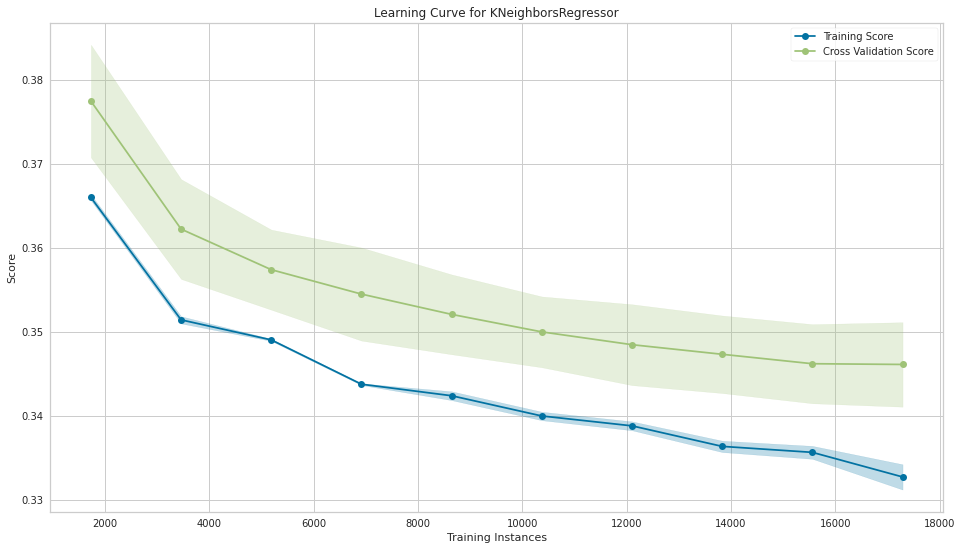

<Figure size 432x288 with 0 Axes>

In [71]:
fig, ax = plt.subplots(figsize=(16, 9))
l_curve = LearningCurve(KNeighborsRegressor(n_neighbors=best_k), 
                        train_sizes=np.arange(.1, 1.01, .1),
                        scoring=rmse_score, 
                        cv=5, 
                        ax=ax)
l_curve.fit(X, y)
l_curve.poof()
sns.despine()
fig.tight_layout();